In [1]:
import cv2
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow_addons.metrics import F1Score
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Reshape, UpSampling2D, Input, Conv2DTranspose, Concatenate
from keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, MaxPool2D, Activation, MaxPooling2D, Rescaling
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
data_dir = '/Users/PaulPlay/PaulPlay with python/Deep Learning/Weed classifier/Data/'

train_path = 'train/*/*.png' 
val_path = 'val/*/*.png'
test_path = 'test/*/*.png'

In [4]:
def load_image(path):
    ScaleTo = 100  # px to scale
    seed = 7  # fixing random

    img_path = '/Users/PaulPlay/PaulPlay with python/Deep Learning/Weed classifier/Data/' + path
    files = glob(img_path)

    trainImg = []
    trainLabel = []
    j = 1
    num = len(files)

  # Obtain images and resizing, obtain labels
    for img in files:
        print(str(j) + "/" + str(num), end="\r")
        trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))  # Get image (with resizing)
        trainLabel.append(img.split('\\')[-2])  # Get image label (folder name)
        j += 1

    X = np.array(trainImg)  # images set
    Y = np.array(trainLabel)  # labels set
    return X, Y

In [5]:
x_train, y_train = load_image(train_path)
x_val, y_val = load_image(val_path)
x_test, y_test = load_image(test_path)

In [6]:
x_train.shape, x_val.shape, x_test.shape, y_train.shape

((1287, 100, 100, 3), (389, 100, 100, 3), (412, 100, 100, 3), (1287,))

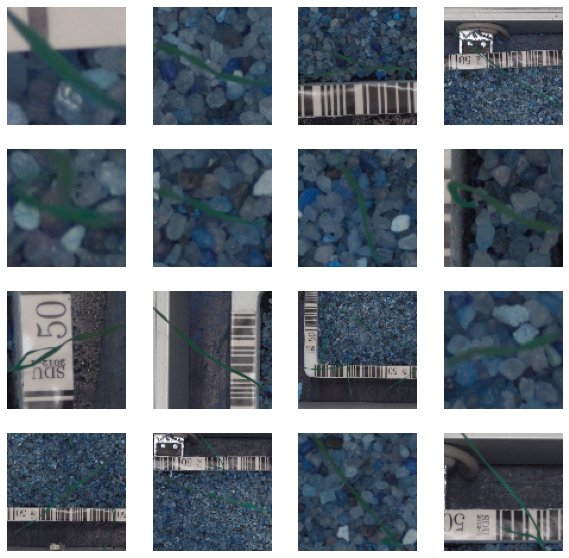

In [7]:
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(x_train[i])
    # plt.title(class_names[labels[i]])
  plt.axis("off")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Frequency (Count)')

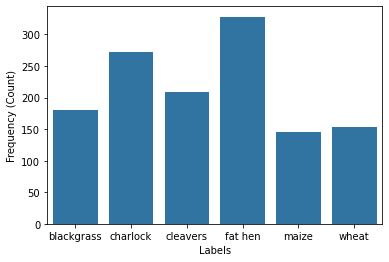

In [8]:
color = sns.color_palette()[0]
sns.countplot(y_train, color=color);
plt.xlabel('Labels')
plt.ylabel('Frequency (Count)')

In [9]:
def image_prep(x_set):
    clearTrainImg = []
    examples = []; getEx = True
    for img in x_set:

    # Use gaussian blur
        blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
        hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
        lower_green = (25, 40, 50)
        upper_green = (75, 255, 255)
        mask = cv2.inRange(hsvImg, lower_green, upper_green)  
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
        bMask = mask > 0  
    
    # Apply the mask
        clear = np.zeros_like(img, np.uint8)  # Create empty image
        clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
        clearTrainImg.append(clear)  # Append image without backgroung
    transformed_data = np.asarray(clearTrainImg)
    # Show examples
    if getEx:
        plt.figure(figsize=(10,10))
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False
    return transformed_data


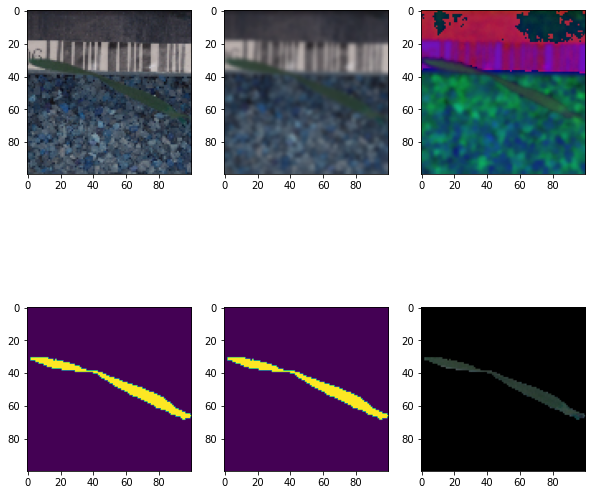

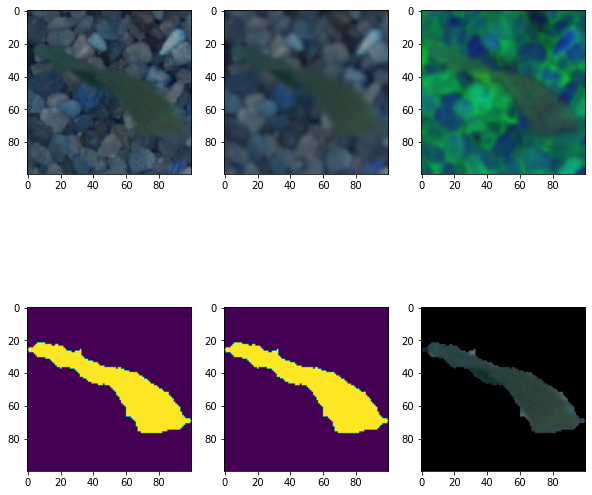

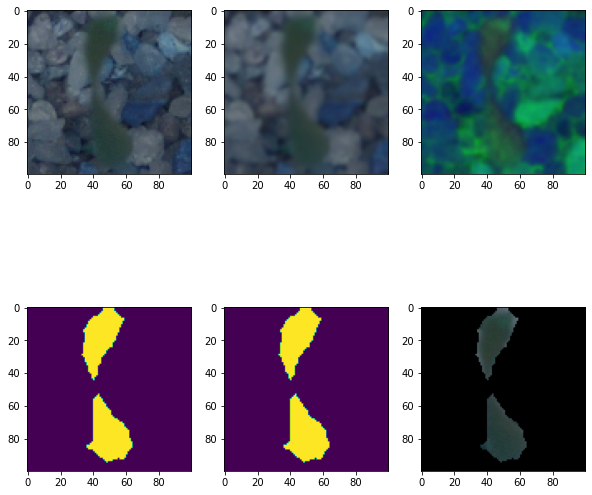

In [10]:
X_train = image_prep(x_train)
X_val = image_prep(x_val)
X_test = image_prep(x_test)

In [11]:
X_train.shape, X_val.shape

((1287, 100, 100, 3), (389, 100, 100, 3))

In [12]:
# def data_normalization(_set):
#     data = _set / 255
#     return data

In [13]:
# X_train = data_normalization(X_train)
# X_val = data_normalization(X_val)
# X_test = data_normalization(X_test)

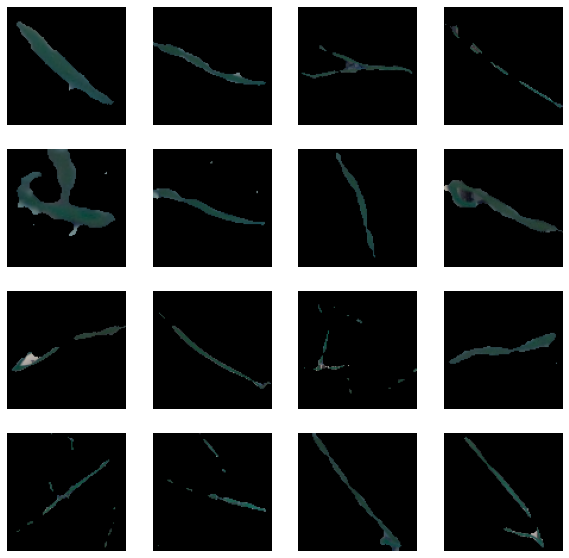

In [14]:

# plot an image in each of the subfolders respectively
fig, ax = plt.subplots(4, 4, figsize=(10, 10))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i])
    # plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
def y_encoder(y_train, y_val, y_test):

# Encode labels and create classes
    le = LabelEncoder()
    le.fit(y_train)
    y_train = le.transform(y_train)
    y_val = le.transform(y_val)
    y_test = le.transform(y_test)
    print("Classes: " + str(le.classes_))

# Make labels categorical
    y_train = keras.utils.to_categorical(y_train)
    y_val = keras.utils.to_categorical(y_val)
    y_test = keras.utils.to_categorical(y_test)
    num_clases = y_train.shape[1]
    print("Number of classes: " + str(num_clases))

    return y_train, y_val, y_test
le = LabelEncoder().fit(y_train) 
classes = le.classes_

In [16]:
Y_train, Y_val, Y_test = y_encoder(y_train, y_val, y_test)


Classes: ['blackgrass' 'charlock' 'cleavers' 'fat hen' 'maize' 'wheat']
Number of classes: 6


In [17]:
datagen = ImageDataGenerator(rescale=1./255,
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,
        vertical_flip=True  # randomly flip images vertically
    )  
testgen = ImageDataGenerator(rescale=1./255)

In [18]:
datagen.fit(X_train)
train_ds = datagen.flow(X_train, Y_train, batch_size=16)

datagen.fit(X_val)
val_ds = datagen.flow(X_val, Y_val, batch_size=16)

testgen.fit(X_test)
test_ds = testgen.flow(X_test, Y_test, shuffle=False, batch_size=16)

In [19]:
# datagen.fit(x_train)
# Train = datagen.flow(x_train, Y_train)

# datagen.fit(x_val)
# Val = datagen.flow(x_val, Y_val)

# testgen.fit(x_test)
# Test = testgen.flow(x_test, y_test, shuffle=False)

In [20]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(100, 100, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(61, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(6, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 128)       1

In [21]:
metrics = ['accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.TruePositives(name='truepositives'),
        tf.keras.metrics.FalsePositives(name='falsepositives'),
        tf.keras.metrics.AUC(name='auc')]

# compile the model   
model.compile(optimizer='adam',
        loss='categorical_crossentropy',
        metrics=metrics)

# create callbacks  
checkpoint = ModelCheckpoint(filepath='plant_best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, min_lr=0.000001)
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=10, mode='min', restore_best_weights=True)

In [22]:
# model.load_weights('best_weights.hdf5')

In [23]:
# Fitting the model
hist = model.fit(train_ds,
                 epochs=100, validation_data=val_ds)

Epoch 1/100
81/81 [==============================] - 41s 110ms/step - loss: 1.8792 - accuracy: 0.3038 - precision: 0.3606 - recall: 0.1818 - truepositives: 234.0000 - falsepositives: 415.0000 - auc: 0.6785 - val_loss: 1.9614 - val_accuracy: 0.2828 - val_precision: 0.3255 - val_recall: 0.1774 - val_truepositives: 69.0000 - val_falsepositives: 143.0000 - val_auc: 0.6573
Epoch 2/100
81/81 [==============================] - 7s 85ms/step - loss: 1.5020 - accuracy: 0.4087 - precision: 0.5014 - recall: 0.2821 - truepositives: 363.0000 - falsepositives: 361.0000 - auc: 0.7817 - val_loss: 3.8238 - val_accuracy: 0.1465 - val_precision: 0.1827 - val_recall: 0.1465 - val_truepositives: 57.0000 - val_falsepositives: 255.0000 - val_auc: 0.5181
Epoch 3/100
81/81 [==============================] - 7s 88ms/step - loss: 1.2764 - accuracy: 0.5066 - precision: 0.5641 - recall: 0.3761 - truepositives: 484.0000 - falsepositives: 374.0000 - auc: 0.8405 - val_loss: 4.4746 - val_accuracy: 0.2288 - val_precisio

81/81 [==============================] - 7s 91ms/step - loss: 0.4628 - accuracy: 0.8477 - precision: 0.8686 - recall: 0.8221 - truepositives: 1058.0000 - falsepositives: 160.0000 - auc: 0.9756 - val_loss: 2.1115 - val_accuracy: 0.5373 - val_precision: 0.5391 - val_recall: 0.5321 - val_truepositives: 207.0000 - val_falsepositives: 177.0000 - val_auc: 0.8390
Epoch 46/100
81/81 [==============================] - 7s 90ms/step - loss: 0.4391 - accuracy: 0.8384 - precision: 0.8603 - recall: 0.8182 - truepositives: 1053.0000 - falsepositives: 171.0000 - auc: 0.9791 - val_loss: 1.0993 - val_accuracy: 0.6504 - val_precision: 0.6585 - val_recall: 0.6195 - val_truepositives: 241.0000 - val_falsepositives: 125.0000 - val_auc: 0.9079
Epoch 47/100
81/81 [==============================] - 7s 91ms/step - loss: 0.4652 - accuracy: 0.8384 - precision: 0.8679 - recall: 0.8166 - truepositives: 1051.0000 - falsepositives: 160.0000 - auc: 0.9763 - val_loss: 0.6656 - val_accuracy: 0.7609 - val_precision: 0.77

81/81 [==============================] - 7s 91ms/step - loss: 0.2741 - accuracy: 0.8998 - precision: 0.9154 - recall: 0.8912 - truepositives: 1147.0000 - falsepositives: 106.0000 - auc: 0.9916 - val_loss: 0.3522 - val_accuracy: 0.8638 - val_precision: 0.8844 - val_recall: 0.8458 - val_truepositives: 329.0000 - val_falsepositives: 43.0000 - val_auc: 0.9849
Epoch 90/100
81/81 [==============================] - 7s 91ms/step - loss: 0.2589 - accuracy: 0.9153 - precision: 0.9262 - recall: 0.9068 - truepositives: 1167.0000 - falsepositives: 93.0000 - auc: 0.9917 - val_loss: 0.3152 - val_accuracy: 0.8895 - val_precision: 0.9010 - val_recall: 0.8895 - val_truepositives: 346.0000 - val_falsepositives: 38.0000 - val_auc: 0.9896
Epoch 91/100
81/81 [==============================] - 7s 92ms/step - loss: 0.3175 - accuracy: 0.8974 - precision: 0.9095 - recall: 0.8897 - truepositives: 1145.0000 - falsepositives: 114.0000 - auc: 0.9871 - val_loss: 0.4262 - val_accuracy: 0.8509 - val_precision: 0.8636 

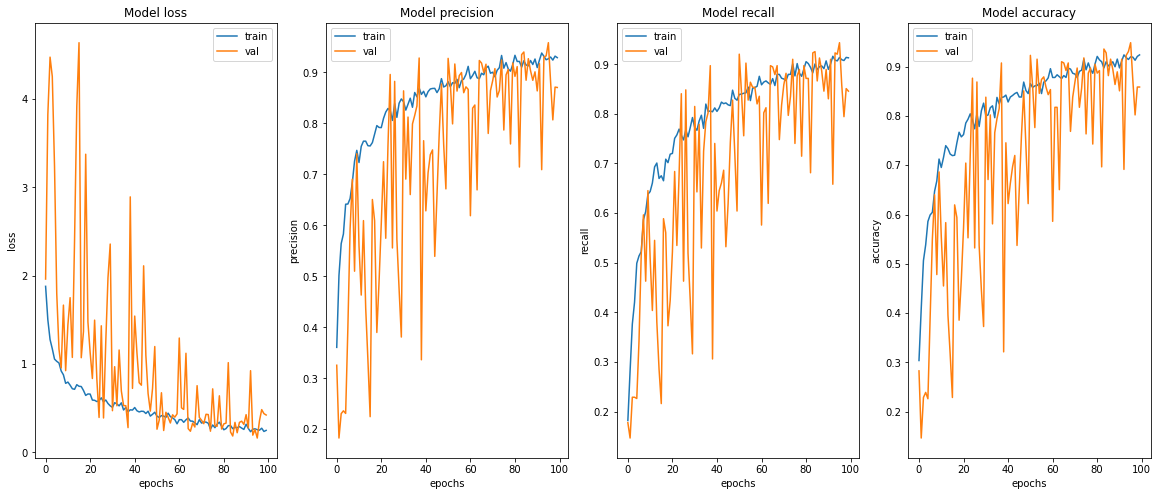

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 8))
ax = ax.ravel()
# plot the graph of the metrics
for i, met in enumerate(['loss', 'precision', 'recall', 'accuracy']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
# Fitting the model
hist = model.fit(train_ds,
                 epochs=50,
                 validation_data=val_ds,
                 callbacks=[lr_reduce, checkpoint])

Epoch 1/50
81/81 [==============================] - 8s 94ms/step - loss: 0.2781 - accuracy: 0.9114 - precision: 0.9190 - recall: 0.9083 - truepositives: 1169.0000 - falsepositives: 103.0000 - auc: 0.9908 - val_loss: 0.5679 - val_accuracy: 0.7995 - val_precision: 0.8266 - val_recall: 0.7841 - val_truepositives: 305.0000 - val_falsepositives: 64.0000 - val_auc: 0.9697 - lr: 0.0010
Epoch 2/50
81/81 [==============================] - 8s 94ms/step - loss: 0.2448 - accuracy: 0.9239 - precision: 0.9348 - recall: 0.9138 - truepositives: 1176.0000 - falsepositives: 82.0000 - auc: 0.9908 - val_loss: 0.2276 - val_accuracy: 0.9177 - val_precision: 0.9293 - val_recall: 0.9126 - val_truepositives: 355.0000 - val_falsepositives: 27.0000 - val_auc: 0.9932 - lr: 0.0010
Epoch 3/50
81/81 [==============================] - 8s 92ms/step - loss: 0.2320 - accuracy: 0.9324 - precision: 0.9404 - recall: 0.9200 - truepositives: 1184.0000 - falsepositives: 75.0000 - auc: 0.9925 - val_loss: 0.3417 - val_accuracy:

Epoch 22/50
81/81 [==============================] - 8s 93ms/step - loss: 0.1668 - accuracy: 0.9479 - precision: 0.9537 - recall: 0.9448 - truepositives: 1216.0000 - falsepositives: 59.0000 - auc: 0.9961 - val_loss: 0.1298 - val_accuracy: 0.9563 - val_precision: 0.9563 - val_recall: 0.9563 - val_truepositives: 372.0000 - val_falsepositives: 17.0000 - val_auc: 0.9980 - lr: 3.0000e-04
Epoch 23/50
81/81 [==============================] - 8s 94ms/step - loss: 0.1665 - accuracy: 0.9464 - precision: 0.9520 - recall: 0.9409 - truepositives: 1211.0000 - falsepositives: 61.0000 - auc: 0.9959 - val_loss: 0.1816 - val_accuracy: 0.9409 - val_precision: 0.9456 - val_recall: 0.9383 - val_truepositives: 365.0000 - val_falsepositives: 21.0000 - val_auc: 0.9930 - lr: 3.0000e-04
Epoch 24/50
81/81 [==============================] - 8s 93ms/step - loss: 0.1929 - accuracy: 0.9425 - precision: 0.9468 - recall: 0.9409 - truepositives: 1211.0000 - falsepositives: 68.0000 - auc: 0.9936 - val_loss: 0.1174 - val

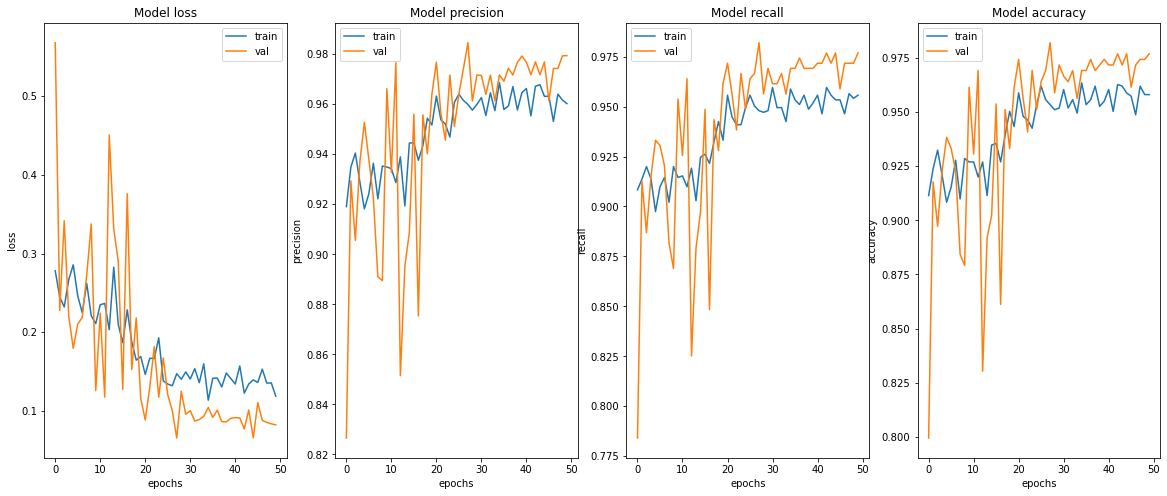

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 8))
ax = ax.ravel()
# plot the graph of the metrics
for i, met in enumerate(['loss', 'precision', 'recall', 'accuracy']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, acc, precision, rec, truepositives, falsepositives, auc = model.evaluate(test_ds)

26/26 [==============================] - 1s 56ms/step - loss: 0.0618 - accuracy: 0.9757 - precision: 0.9781 - recall: 0.9757 - truepositives: 402.0000 - falsepositives: 9.0000 - auc: 0.9996


In [29]:
## FUnction to create a dataframe for results
def createResultDf(name, losss, accuracy, precision, recall,
                   truepositives, falsepositives, auc):
    result = pd.DataFrame({'CNN Arch':[name], 'Loss':[loss], 'Test Score': [accuracy],
                           'Precision':[precision], 'Recall':[recall], 'TruePositives':[truepositives],
                           'FalsePositives':[falsepositives], 'AUC':[auc]})
    return result

In [30]:
resultDF = createResultDf("model", loss, acc, precision, rec, truepositives, falsepositives, auc)

resultDF

,CNN Arch,Loss,Test Score,Precision,Recall,TruePositives,FalsePositives,AUC
0,model,0.061842,0.975728,0.978102,0.975728,402.0,9.0,0.999611


In [31]:
def report(test_ds, model):
# Predict the values from the validation dataset
    y_pred = model.predict(test_ds)
    predYClasses = np.argmax(y_pred, axis = 1) 
    trueY = np.argmax(test_ds.y, axis = 1) 

# confusion matrix

    conf_matrix = confusion_matrix(trueY, predYClasses)
    # Plots the cinfusion_matrix
    fig,ax=plt.subplots(1,1,figsize=(14,7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes);
    cl_report = classification_report(trueY, predYClasses, target_names=classes)
    
    print(cl_report)

              precision    recall  f1-score   support

  blackgrass       0.98      0.95      0.97        60
    charlock       0.97      1.00      0.98        90
    cleavers       1.00      0.97      0.99        68
     fat hen       1.00      0.97      0.98       100
       maize       0.94      0.98      0.96        46
       wheat       0.94      0.98      0.96        48

    accuracy                           0.98       412
   macro avg       0.97      0.97      0.97       412
weighted avg       0.98      0.98      0.98       412



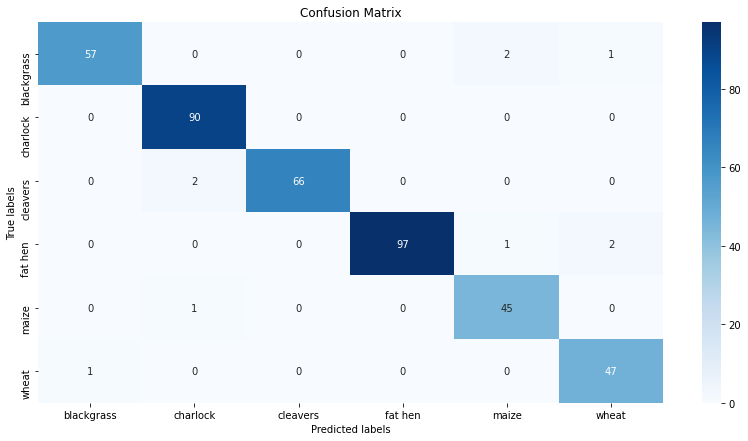

In [32]:
report(test_ds, model)

## Other Architectures

### MobileNetV2

In [33]:
# Create the base model MobileNetV3 from the pre-trained model 
MobileNetV2 = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                                include_top=True,
                                                classes=6,
                                                weights=None)
MobileNetV2.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 16, 16, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 16, 16, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 16, 16, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 16, 16, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 8, 8, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 8, 8, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 8, 8, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 8, 8, 96)    384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 8, 8, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 8, 8, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 8, 8, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 4, 4, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 4, 4, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 4, 4, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 4, 4, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [34]:
MobileNetV2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=['categorical_crossentropy'],
              metrics=metrics)

In [35]:
# train the model
history = MobileNetV2.fit(train_ds,
                 validation_data=val_ds,
                 epochs=100)

Epoch 1/100
81/81 [==============================] - 13s 99ms/step - loss: 2.2873 - accuracy: 0.3038 - precision: 0.5801 - recall: 0.3814 - truepositives: 648.0000 - falsepositives: 469.0000 - auc: 0.8082 - val_loss: 1.8094 - val_accuracy: 0.1131 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_truepositives: 0.0000e+00 - val_falsepositives: 0.0000e+00 - val_auc: 0.5341
Epoch 2/100
81/81 [==============================] - 6s 71ms/step - loss: 1.2838 - accuracy: 0.4981 - precision: 0.5748 - recall: 0.3256 - truepositives: 419.0000 - falsepositives: 310.0000 - auc: 0.8400 - val_loss: 1.8769 - val_accuracy: 0.2519 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_truepositives: 0.0000e+00 - val_falsepositives: 0.0000e+00 - val_auc: 0.5409
Epoch 3/100
81/81 [==============================] - 6s 71ms/step - loss: 1.0313 - accuracy: 0.6107 - precision: 0.6844 - recall: 0.4988 - truepositives: 642.0000 - falsepositives: 296.0000 - auc: 0.8942 - val_loss: 2.2368 - val_accura

Epoch 23/100
81/81 [==============================] - 6s 72ms/step - loss: 0.4552 - accuracy: 0.8469 - precision: 0.8728 - recall: 0.8213 - truepositives: 1057.0000 - falsepositives: 154.0000 - auc: 0.9765 - val_loss: 8.2701 - val_accuracy: 0.1825 - val_precision: 0.1825 - val_recall: 0.1825 - val_truepositives: 71.0000 - val_falsepositives: 318.0000 - val_auc: 0.5314
Epoch 24/100
81/81 [==============================] - 6s 71ms/step - loss: 0.4363 - accuracy: 0.8524 - precision: 0.8734 - recall: 0.8252 - truepositives: 1062.0000 - falsepositives: 154.0000 - auc: 0.9783 - val_loss: 11.7153 - val_accuracy: 0.1517 - val_precision: 0.1517 - val_recall: 0.1517 - val_truepositives: 59.0000 - val_falsepositives: 330.0000 - val_auc: 0.5073
Epoch 25/100
81/81 [==============================] - 6s 71ms/step - loss: 0.4766 - accuracy: 0.8337 - precision: 0.8612 - recall: 0.8096 - truepositives: 1042.0000 - falsepositives: 168.0000 - auc: 0.9752 - val_loss: 11.8515 - val_accuracy: 0.2494 - val_pr

Epoch 45/100
81/81 [==============================] - 6s 72ms/step - loss: 0.3083 - accuracy: 0.9037 - precision: 0.9201 - recall: 0.8858 - truepositives: 1140.0000 - falsepositives: 99.0000 - auc: 0.9887 - val_loss: 18.8029 - val_accuracy: 0.3085 - val_precision: 0.3085 - val_recall: 0.3085 - val_truepositives: 120.0000 - val_falsepositives: 269.0000 - val_auc: 0.6088
Epoch 46/100
81/81 [==============================] - 6s 72ms/step - loss: 0.3762 - accuracy: 0.8803 - precision: 0.8986 - recall: 0.8609 - truepositives: 1108.0000 - falsepositives: 125.0000 - auc: 0.9823 - val_loss: 20.9830 - val_accuracy: 0.2699 - val_precision: 0.2720 - val_recall: 0.2699 - val_truepositives: 105.0000 - val_falsepositives: 281.0000 - val_auc: 0.6193
Epoch 47/100
81/81 [==============================] - 6s 71ms/step - loss: 0.3285 - accuracy: 0.8951 - precision: 0.9138 - recall: 0.8811 - truepositives: 1134.0000 - falsepositives: 107.0000 - auc: 0.9858 - val_loss: 16.2076 - val_accuracy: 0.2314 - val_

81/81 [==============================] - 6s 74ms/step - loss: 0.2713 - accuracy: 0.9099 - precision: 0.9255 - recall: 0.8974 - truepositives: 1155.0000 - falsepositives: 93.0000 - auc: 0.9906 - val_loss: 22.8049 - val_accuracy: 0.2674 - val_precision: 0.2674 - val_recall: 0.2674 - val_truepositives: 104.0000 - val_falsepositives: 285.0000 - val_auc: 0.5677
Epoch 68/100
81/81 [==============================] - 6s 71ms/step - loss: 0.3066 - accuracy: 0.9083 - precision: 0.9161 - recall: 0.8904 - truepositives: 1146.0000 - falsepositives: 105.0000 - auc: 0.9876 - val_loss: 20.0420 - val_accuracy: 0.3111 - val_precision: 0.3127 - val_recall: 0.3111 - val_truepositives: 121.0000 - val_falsepositives: 266.0000 - val_auc: 0.6327
Epoch 69/100
81/81 [==============================] - 6s 73ms/step - loss: 0.2823 - accuracy: 0.9060 - precision: 0.9180 - recall: 0.8959 - truepositives: 1153.0000 - falsepositives: 103.0000 - auc: 0.9900 - val_loss: 18.6235 - val_accuracy: 0.4190 - val_precision: 0.

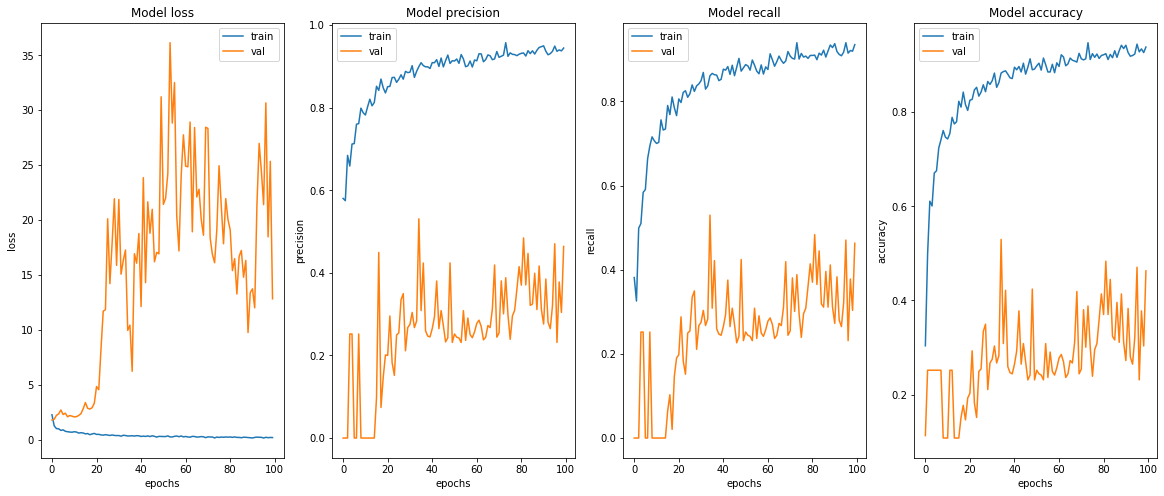

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 8))
ax = ax.ravel()
# plot the graph of the metrics
for i, met in enumerate(['loss', 'precision', 'recall', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [37]:
MobileNet_checkpoint = ModelCheckpoint(filepath='plant_weights_MobileNet.hdf5', save_best_only=True, save_weights_only=True)


In [38]:
# Fitting the model
hist = MobileNetV2.fit(train_ds,
                 epochs=50,
                 validation_data=val_ds,
                 callbacks=[lr_reduce, checkpoint])

Epoch 1/50
81/81 [==============================] - 6s 72ms/step - loss: 0.2075 - accuracy: 0.9332 - precision: 0.9444 - recall: 0.9239 - truepositives: 1189.0000 - falsepositives: 70.0000 - auc: 0.9941 - val_loss: 21.0182 - val_accuracy: 0.2828 - val_precision: 0.2835 - val_recall: 0.2828 - val_truepositives: 110.0000 - val_falsepositives: 278.0000 - val_auc: 0.5996 - lr: 0.0100
Epoch 2/50
81/81 [==============================] - 6s 72ms/step - loss: 0.2031 - accuracy: 0.9332 - precision: 0.9416 - recall: 0.9277 - truepositives: 1194.0000 - falsepositives: 74.0000 - auc: 0.9930 - val_loss: 8.7338 - val_accuracy: 0.4704 - val_precision: 0.4766 - val_recall: 0.4704 - val_truepositives: 183.0000 - val_falsepositives: 201.0000 - val_auc: 0.7296 - lr: 0.0100
Epoch 3/50
81/81 [==============================] - 6s 73ms/step - loss: 0.2021 - accuracy: 0.9347 - precision: 0.9439 - recall: 0.9277 - truepositives: 1194.0000 - falsepositives: 71.0000 - auc: 0.9941 - val_loss: 14.9603 - val_accura

Epoch 22/50
81/81 [==============================] - 6s 72ms/step - loss: 0.0887 - accuracy: 0.9728 - precision: 0.9750 - recall: 0.9705 - truepositives: 1249.0000 - falsepositives: 32.0000 - auc: 0.9987 - val_loss: 0.9310 - val_accuracy: 0.8201 - val_precision: 0.8251 - val_recall: 0.8123 - val_truepositives: 316.0000 - val_falsepositives: 67.0000 - val_auc: 0.9542 - lr: 0.0030
Epoch 23/50
81/81 [==============================] - 6s 72ms/step - loss: 0.1017 - accuracy: 0.9674 - precision: 0.9702 - recall: 0.9627 - truepositives: 1239.0000 - falsepositives: 38.0000 - auc: 0.9984 - val_loss: 0.8840 - val_accuracy: 0.8406 - val_precision: 0.8482 - val_recall: 0.8329 - val_truepositives: 324.0000 - val_falsepositives: 58.0000 - val_auc: 0.9530 - lr: 0.0030
Epoch 24/50
81/81 [==============================] - 6s 73ms/step - loss: 0.0892 - accuracy: 0.9713 - precision: 0.9735 - recall: 0.9705 - truepositives: 1249.0000 - falsepositives: 34.0000 - auc: 0.9983 - val_loss: 1.1370 - val_accurac

Epoch 43/50
81/81 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9775 - precision: 0.9774 - recall: 0.9767 - truepositives: 1257.0000 - falsepositives: 29.0000 - auc: 0.9987
Epoch 43: ReduceLROnPlateau reducing learning rate to 0.00026999999536201356.
81/81 [==============================] - 6s 73ms/step - loss: 0.0710 - accuracy: 0.9775 - precision: 0.9774 - recall: 0.9767 - truepositives: 1257.0000 - falsepositives: 29.0000 - auc: 0.9987 - val_loss: 0.1228 - val_accuracy: 0.9769 - val_precision: 0.9769 - val_recall: 0.9769 - val_truepositives: 380.0000 - val_falsepositives: 9.0000 - val_auc: 0.9935 - lr: 9.0000e-04
Epoch 44/50
81/81 [==============================] - 6s 72ms/step - loss: 0.0462 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9837 - truepositives: 1266.0000 - falsepositives: 19.0000 - auc: 0.9993 - val_loss: 0.0893 - val_accuracy: 0.9769 - val_precision: 0.9769 - val_recall: 0.9769 - val_truepositives: 380.0000 - val_falsepositives: 9.0000 

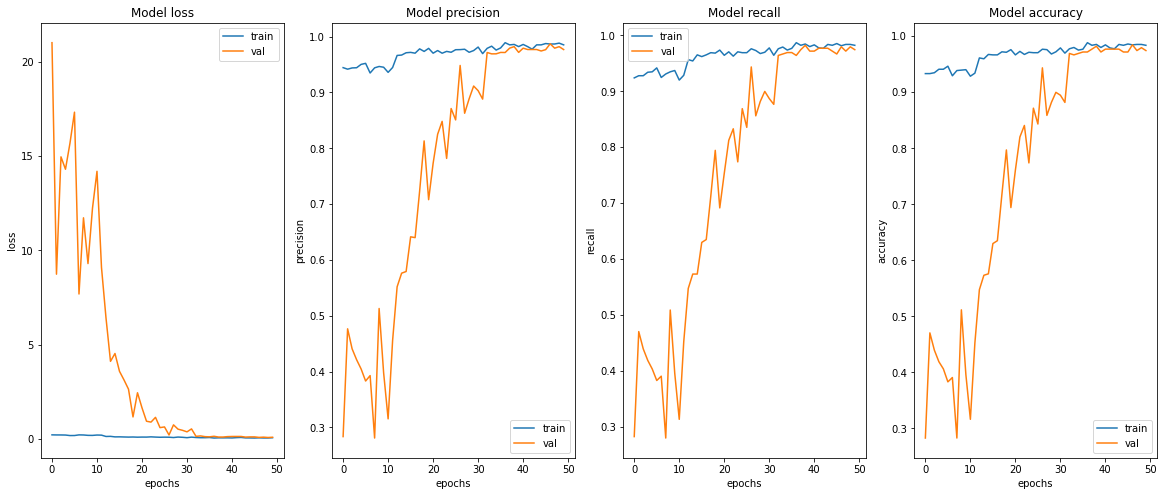

In [39]:
fig, ax = plt.subplots(1, 4, figsize=(20, 8))
ax = ax.ravel()
# plot the graph of the metrics
for i, met in enumerate(['loss', 'precision', 'recall', 'accuracy']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [40]:
MobileNetV2.load_weights('plant_weights_MobileNet.hdf5')

In [41]:
loss, acc, precision, rec, truepositives, falsepositives, auc = MobileNetV2.evaluate(test_ds)

26/26 [==============================] - 1s 28ms/step - loss: 0.0889 - accuracy: 0.9782 - precision: 0.9780 - recall: 0.9709 - truepositives: 400.0000 - falsepositives: 9.0000 - auc: 0.9992


In [42]:
resultDF1 = pd.concat([resultDF, createResultDf("MobileNetV2", loss, acc, precision, rec, truepositives, falsepositives, auc)])

resultDF1

,CNN Arch,Loss,Test Score,Precision,Recall,TruePositives,FalsePositives,AUC
0,model,0.061842,0.975728,0.978102,0.975728,402.0,9.0,0.999611
0,MobileNetV2,0.088859,0.978155,0.977995,0.970874,400.0,9.0,0.999216


              precision    recall  f1-score   support

  blackgrass       0.97      0.97      0.97        60
    charlock       1.00      1.00      1.00        90
    cleavers       0.99      1.00      0.99        68
     fat hen       1.00      0.96      0.98       100
       maize       0.94      0.98      0.96        46
       wheat       0.94      0.96      0.95        48

    accuracy                           0.98       412
   macro avg       0.97      0.98      0.97       412
weighted avg       0.98      0.98      0.98       412



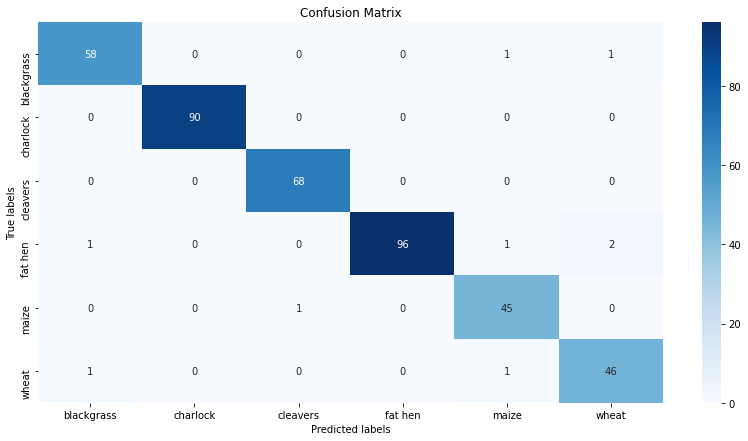

In [43]:
report(test_ds, MobileNetV2)

### Resnet50

In [44]:
# Create the base model ResNet from the pre-trained model 
resnet50 = tf.keras.applications.resnet50.ResNet50(input_shape=(128, 128, 3),
                                                   include_top=True,
                                                   classes=6,
                                                   weights=None)

# model summary()
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [45]:
# compile the model
base_learning_rate = 0.01
resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=['categorical_crossentropy'],
              metrics=metrics)


# base model architecture
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [46]:
# train the model
history = resnet50.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds)

Epoch 1/100
81/81 [==============================] - 23s 210ms/step - loss: 3.6942 - accuracy: 0.2642 - precision: 0.6069 - recall: 0.2990 - truepositives: 508.0000 - falsepositives: 329.0000 - auc: 0.7592 - val_loss: 80299856.0000 - val_accuracy: 0.1131 - val_precision: 0.1131 - val_recall: 0.1131 - val_truepositives: 44.0000 - val_falsepositives: 345.0000 - val_auc: 0.4679
Epoch 2/100
81/81 [==============================] - 15s 185ms/step - loss: 1.5695 - accuracy: 0.4211 - precision: 0.4851 - recall: 0.1515 - truepositives: 195.0000 - falsepositives: 207.0000 - auc: 0.7860 - val_loss: 92.6338 - val_accuracy: 0.1388 - val_precision: 0.1393 - val_recall: 0.1311 - val_truepositives: 51.0000 - val_falsepositives: 315.0000 - val_auc: 0.4805
Epoch 3/100
81/81 [==============================] - 15s 188ms/step - loss: 1.4723 - accuracy: 0.4662 - precision: 0.5217 - recall: 0.2525 - truepositives: 325.0000 - falsepositives: 298.0000 - auc: 0.8092 - val_loss: 2.6535 - val_accuracy: 0.4807 - 

Epoch 23/100
81/81 [==============================] - 15s 187ms/step - loss: 0.5475 - accuracy: 0.8042 - precision: 0.8322 - recall: 0.7708 - truepositives: 992.0000 - falsepositives: 200.0000 - auc: 0.9678 - val_loss: 0.6726 - val_accuracy: 0.7712 - val_precision: 0.8000 - val_recall: 0.7404 - val_truepositives: 288.0000 - val_falsepositives: 72.0000 - val_auc: 0.9518
Epoch 24/100
81/81 [==============================] - 15s 187ms/step - loss: 0.5038 - accuracy: 0.8159 - precision: 0.8412 - recall: 0.7941 - truepositives: 1022.0000 - falsepositives: 193.0000 - auc: 0.9716 - val_loss: 1.0368 - val_accuracy: 0.6787 - val_precision: 0.6948 - val_recall: 0.6555 - val_truepositives: 255.0000 - val_falsepositives: 112.0000 - val_auc: 0.9148
Epoch 25/100
81/81 [==============================] - 15s 187ms/step - loss: 0.5117 - accuracy: 0.8166 - precision: 0.8351 - recall: 0.7871 - truepositives: 1013.0000 - falsepositives: 200.0000 - auc: 0.9716 - val_loss: 0.9737 - val_accuracy: 0.5938 - va

Epoch 45/100
81/81 [==============================] - 15s 189ms/step - loss: 0.3126 - accuracy: 0.8873 - precision: 0.9003 - recall: 0.8702 - truepositives: 1120.0000 - falsepositives: 124.0000 - auc: 0.9895 - val_loss: 0.8502 - val_accuracy: 0.7584 - val_precision: 0.7721 - val_recall: 0.7404 - val_truepositives: 288.0000 - val_falsepositives: 85.0000 - val_auc: 0.9450
Epoch 46/100
81/81 [==============================] - 15s 188ms/step - loss: 0.3033 - accuracy: 0.8897 - precision: 0.9053 - recall: 0.8687 - truepositives: 1118.0000 - falsepositives: 117.0000 - auc: 0.9892 - val_loss: 0.3366 - val_accuracy: 0.8766 - val_precision: 0.8880 - val_recall: 0.8560 - val_truepositives: 333.0000 - val_falsepositives: 42.0000 - val_auc: 0.9871
Epoch 47/100
81/81 [==============================] - 15s 189ms/step - loss: 0.3472 - accuracy: 0.8718 - precision: 0.8826 - recall: 0.8586 - truepositives: 1105.0000 - falsepositives: 147.0000 - auc: 0.9858 - val_loss: 1.2492 - val_accuracy: 0.6221 - va

Epoch 67/100
81/81 [==============================] - 15s 187ms/step - loss: 0.2583 - accuracy: 0.9145 - precision: 0.9284 - recall: 0.9068 - truepositives: 1167.0000 - falsepositives: 90.0000 - auc: 0.9920 - val_loss: 2.0621 - val_accuracy: 0.6067 - val_precision: 0.6404 - val_recall: 0.5861 - val_truepositives: 228.0000 - val_falsepositives: 128.0000 - val_auc: 0.8486
Epoch 68/100
81/81 [==============================] - 15s 188ms/step - loss: 0.2711 - accuracy: 0.9114 - precision: 0.9236 - recall: 0.9021 - truepositives: 1161.0000 - falsepositives: 96.0000 - auc: 0.9908 - val_loss: 0.3795 - val_accuracy: 0.8560 - val_precision: 0.8707 - val_recall: 0.8483 - val_truepositives: 330.0000 - val_falsepositives: 49.0000 - val_auc: 0.9837
Epoch 69/100
81/81 [==============================] - 15s 187ms/step - loss: 0.2230 - accuracy: 0.9200 - precision: 0.9291 - recall: 0.9161 - truepositives: 1179.0000 - falsepositives: 90.0000 - auc: 0.9941 - val_loss: 0.2695 - val_accuracy: 0.9049 - val_

81/81 [==============================] - 15s 189ms/step - loss: 0.2061 - accuracy: 0.9231 - precision: 0.9335 - recall: 0.9169 - truepositives: 1180.0000 - falsepositives: 84.0000 - auc: 0.9944 - val_loss: 0.3036 - val_accuracy: 0.8997 - val_precision: 0.9136 - val_recall: 0.8972 - val_truepositives: 349.0000 - val_falsepositives: 33.0000 - val_auc: 0.9871
Epoch 90/100
81/81 [==============================] - 15s 188ms/step - loss: 0.1774 - accuracy: 0.9394 - precision: 0.9424 - recall: 0.9285 - truepositives: 1195.0000 - falsepositives: 73.0000 - auc: 0.9951 - val_loss: 0.5250 - val_accuracy: 0.8509 - val_precision: 0.8541 - val_recall: 0.8278 - val_truepositives: 322.0000 - val_falsepositives: 55.0000 - val_auc: 0.9720
Epoch 91/100
81/81 [==============================] - 15s 186ms/step - loss: 0.2034 - accuracy: 0.9363 - precision: 0.9373 - recall: 0.9293 - truepositives: 1196.0000 - falsepositives: 80.0000 - auc: 0.9941 - val_loss: 0.3070 - val_accuracy: 0.9229 - val_precision: 0.9

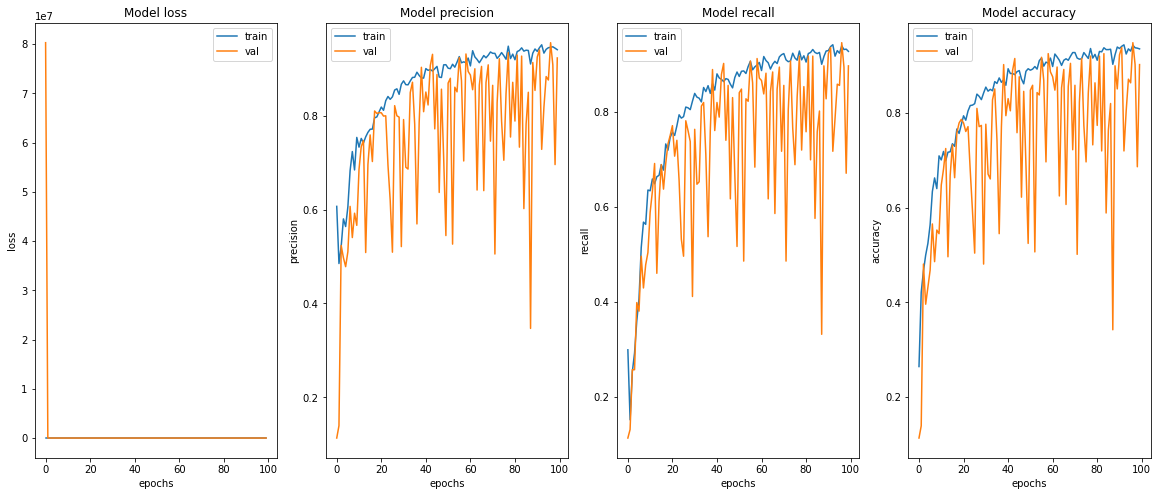

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(20, 8))
ax = ax.ravel()
# plot the graph of the metrics
for i, met in enumerate(['loss', 'precision', 'recall', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [48]:
RestNet_checkpoint = ModelCheckpoint(filepath='plant_clf_restnet50.hdf5', save_best_only=True, save_weights_only=True)

In [49]:
# Fitting the model
history = resnet50.fit(train_ds, 
                       epochs=50, 
                       validation_data=val_ds,
                       callbacks=[checkpoint, lr_reduce])

Epoch 1/50
81/81 [==============================] - 15s 186ms/step - loss: 0.1676 - accuracy: 0.9448 - precision: 0.9506 - recall: 0.9417 - truepositives: 1212.0000 - falsepositives: 63.0000 - auc: 0.9958 - val_loss: 0.3441 - val_accuracy: 0.8715 - val_precision: 0.8915 - val_recall: 0.8663 - val_truepositives: 337.0000 - val_falsepositives: 41.0000 - val_auc: 0.9850 - lr: 0.0100
Epoch 2/50
81/81 [==============================] - 15s 188ms/step - loss: 0.1438 - accuracy: 0.9425 - precision: 0.9482 - recall: 0.9394 - truepositives: 1209.0000 - falsepositives: 66.0000 - auc: 0.9973 - val_loss: 0.4414 - val_accuracy: 0.8972 - val_precision: 0.8969 - val_recall: 0.8946 - val_truepositives: 348.0000 - val_falsepositives: 40.0000 - val_auc: 0.9785 - lr: 0.0100
Epoch 3/50
81/81 [==============================] - 15s 189ms/step - loss: 0.1564 - accuracy: 0.9464 - precision: 0.9520 - recall: 0.9409 - truepositives: 1211.0000 - falsepositives: 61.0000 - auc: 0.9963 - val_loss: 1.1248 - val_accu

Epoch 21/50
81/81 [==============================] - 15s 188ms/step - loss: 0.0569 - accuracy: 0.9790 - precision: 0.9805 - recall: 0.9775 - truepositives: 1258.0000 - falsepositives: 25.0000 - auc: 0.9997 - val_loss: 0.0841 - val_accuracy: 0.9769 - val_precision: 0.9769 - val_recall: 0.9769 - val_truepositives: 380.0000 - val_falsepositives: 9.0000 - val_auc: 0.9981 - lr: 9.0000e-04
Epoch 22/50
81/81 [==============================] - 15s 187ms/step - loss: 0.0551 - accuracy: 0.9814 - precision: 0.9829 - recall: 0.9806 - truepositives: 1262.0000 - falsepositives: 22.0000 - auc: 0.9997 - val_loss: 0.0923 - val_accuracy: 0.9717 - val_precision: 0.9792 - val_recall: 0.9666 - val_truepositives: 376.0000 - val_falsepositives: 8.0000 - val_auc: 0.9980 - lr: 9.0000e-04
Epoch 23/50
81/81 [==============================] - 15s 186ms/step - loss: 0.0642 - accuracy: 0.9759 - precision: 0.9766 - recall: 0.9713 - truepositives: 1250.0000 - falsepositives: 30.0000 - auc: 0.9991 - val_loss: 0.1030 -

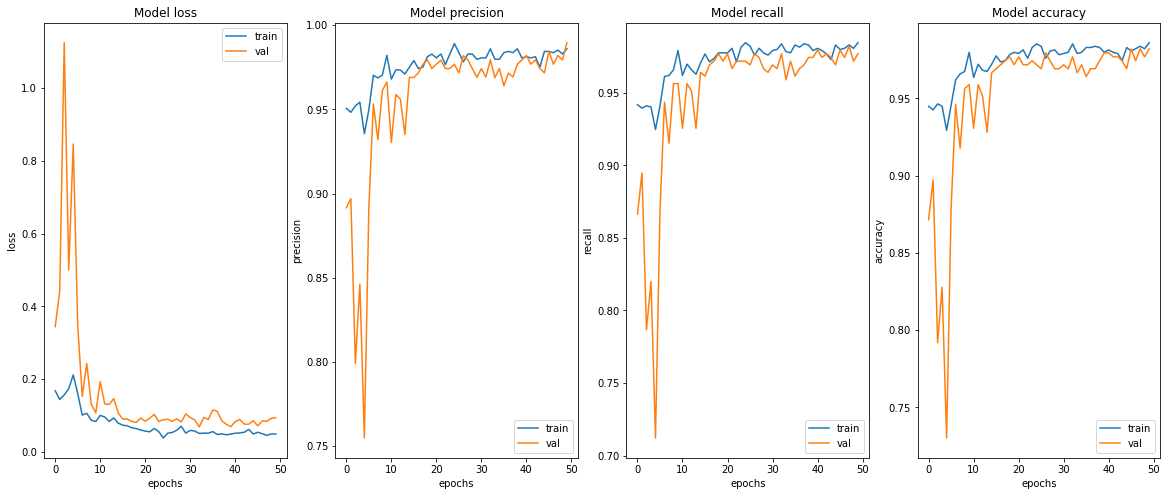

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(20, 8))
ax = ax.ravel()
# plot the graph of the metrics
for i, met in enumerate(['loss', 'precision', 'recall', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [51]:
resnet50.load_weights('plant_clf_restnet50.hdf5')

In [52]:
loss, acc, precision, rec, truepositives, falsepositives, auc = resnet50.evaluate(test_ds)

26/26 [==============================] - 2s 64ms/step - loss: 0.1055 - accuracy: 0.9684 - precision: 0.9708 - recall: 0.9684 - truepositives: 399.0000 - falsepositives: 12.0000 - auc: 0.9979


In [53]:
resultsDf2 = pd.concat([resultDF1, createResultDf("resnet50", loss, acc, precision, rec, truepositives, falsepositives, auc)])

resultsDf2

,CNN Arch,Loss,Test Score,Precision,Recall,TruePositives,FalsePositives,AUC
0,model,0.061842,0.975728,0.978102,0.975728,402.0,9.0,0.999611
0,MobileNetV2,0.088859,0.978155,0.977995,0.970874,400.0,9.0,0.999216
0,resnet50,0.105480,0.968447,0.970803,0.968447,399.0,12.0,0.997856


              precision    recall  f1-score   support

  blackgrass       0.97      0.93      0.95        60
    charlock       0.99      0.99      0.99        90
    cleavers       0.97      0.97      0.97        68
     fat hen       1.00      0.97      0.98       100
       maize       0.92      0.98      0.95        46
       wheat       0.92      0.96      0.94        48

    accuracy                           0.97       412
   macro avg       0.96      0.97      0.96       412
weighted avg       0.97      0.97      0.97       412



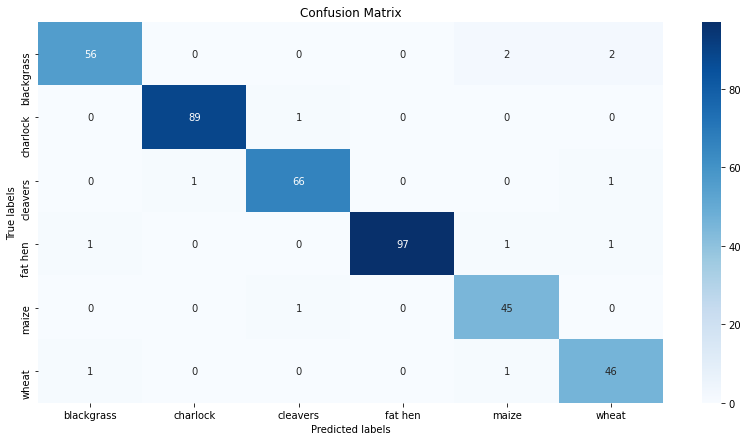

In [54]:
report(test_ds, resnet50)

### Xception

In [55]:
Xception = tf.keras.applications.xception.Xception(input_shape=(128, 128, 3),
                                                   include_top=True,
                                                   classes=6,
                                                   weights=None)
Xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_3[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 16, 16, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv2d_8 (Conv2D)              (None, 8, 8, 728)    186368      ['add_1[0][0]']                  
                                                                                                  
 block4_po

                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 8, 8, 728)   2912        ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 8, 8, 728)   0           ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block7_sepconv2 (SeparableConv  (None, 8, 8, 728)   536536      ['block7_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_se

                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 8, 8, 728)   536536      ['block10_sepconv1_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block10_sepconv1_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block10_sepconv1[0][0]']       
 alization)                                                                                       
          

 block12_sepconv3 (SeparableCon  (None, 8, 8, 728)   536536      ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (Add)                   (None, 8, 8, 728)    0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_9[0][0]']                  
                                                                                                  
 block13_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_10[0][0]']                 
 on)      

In [56]:
base_learning_rate = 0.001
Xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=['categorical_crossentropy'],
              metrics=metrics)


In [57]:
# train the model
history = Xception.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds)

Epoch 1/100
81/81 [==============================] - 25s 236ms/step - loss: 1.2538 - accuracy: 0.5369 - precision: 0.7045 - recall: 0.5809 - truepositives: 987.0000 - falsepositives: 414.0000 - auc: 0.9144 - val_loss: 1.7894 - val_accuracy: 0.2519 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_truepositives: 0.0000e+00 - val_falsepositives: 0.0000e+00 - val_auc: 0.5206
Epoch 2/100
81/81 [==============================] - 17s 214ms/step - loss: 0.8752 - accuracy: 0.6713 - precision: 0.6983 - recall: 0.6169 - truepositives: 794.0000 - falsepositives: 343.0000 - auc: 0.9255 - val_loss: 1.8004 - val_accuracy: 0.1080 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_truepositives: 0.0000e+00 - val_falsepositives: 0.0000e+00 - val_auc: 0.4941
Epoch 3/100
81/81 [==============================] - 18s 217ms/step - loss: 0.6185 - accuracy: 0.7855 - precision: 0.8101 - recall: 0.7591 - truepositives: 977.0000 - falsepositives: 229.0000 - auc: 0.9603 - val_loss: 1.8427 - val_a

Epoch 23/100
81/81 [==============================] - 17s 214ms/step - loss: 0.2742 - accuracy: 0.9138 - precision: 0.9215 - recall: 0.9029 - truepositives: 1162.0000 - falsepositives: 99.0000 - auc: 0.9897 - val_loss: 0.2140 - val_accuracy: 0.9332 - val_precision: 0.9426 - val_recall: 0.9280 - val_truepositives: 361.0000 - val_falsepositives: 22.0000 - val_auc: 0.9944
Epoch 24/100
81/81 [==============================] - 17s 215ms/step - loss: 0.2353 - accuracy: 0.9207 - precision: 0.9290 - recall: 0.9145 - truepositives: 1177.0000 - falsepositives: 90.0000 - auc: 0.9915 - val_loss: 0.8967 - val_accuracy: 0.8149 - val_precision: 0.8144 - val_recall: 0.8123 - val_truepositives: 316.0000 - val_falsepositives: 72.0000 - val_auc: 0.9532
Epoch 25/100
81/81 [==============================] - 18s 216ms/step - loss: 0.2177 - accuracy: 0.9200 - precision: 0.9311 - recall: 0.9130 - truepositives: 1175.0000 - falsepositives: 87.0000 - auc: 0.9939 - val_loss: 2.3542 - val_accuracy: 0.6658 - val_p

81/81 [==============================] - 17s 214ms/step - loss: 0.1602 - accuracy: 0.9464 - precision: 0.9499 - recall: 0.9425 - truepositives: 1213.0000 - falsepositives: 64.0000 - auc: 0.9965 - val_loss: 0.4424 - val_accuracy: 0.8535 - val_precision: 0.8723 - val_recall: 0.8432 - val_truepositives: 328.0000 - val_falsepositives: 48.0000 - val_auc: 0.9803
Epoch 46/100
81/81 [==============================] - 17s 215ms/step - loss: 0.1535 - accuracy: 0.9542 - precision: 0.9584 - recall: 0.9479 - truepositives: 1220.0000 - falsepositives: 53.0000 - auc: 0.9963 - val_loss: 0.1233 - val_accuracy: 0.9640 - val_precision: 0.9663 - val_recall: 0.9589 - val_truepositives: 373.0000 - val_falsepositives: 13.0000 - val_auc: 0.9969
Epoch 47/100
81/81 [==============================] - 17s 214ms/step - loss: 0.1779 - accuracy: 0.9472 - precision: 0.9526 - recall: 0.9378 - truepositives: 1207.0000 - falsepositives: 60.0000 - auc: 0.9946 - val_loss: 1.3789 - val_accuracy: 0.7763 - val_precision: 0.7

81/81 [==============================] - 18s 223ms/step - loss: 0.0992 - accuracy: 0.9627 - precision: 0.9678 - recall: 0.9588 - truepositives: 1234.0000 - falsepositives: 41.0000 - auc: 0.9981 - val_loss: 0.1483 - val_accuracy: 0.9486 - val_precision: 0.9510 - val_recall: 0.9486 - val_truepositives: 369.0000 - val_falsepositives: 19.0000 - val_auc: 0.9982
Epoch 90/100
81/81 [==============================] - 18s 222ms/step - loss: 0.0890 - accuracy: 0.9728 - precision: 0.9743 - recall: 0.9713 - truepositives: 1250.0000 - falsepositives: 33.0000 - auc: 0.9976 - val_loss: 0.2619 - val_accuracy: 0.9383 - val_precision: 0.9381 - val_recall: 0.9357 - val_truepositives: 364.0000 - val_falsepositives: 24.0000 - val_auc: 0.9872
Epoch 91/100
81/81 [==============================] - 18s 224ms/step - loss: 0.0917 - accuracy: 0.9697 - precision: 0.9719 - recall: 0.9674 - truepositives: 1245.0000 - falsepositives: 36.0000 - auc: 0.9982 - val_loss: 0.1496 - val_accuracy: 0.9563 - val_precision: 0.9

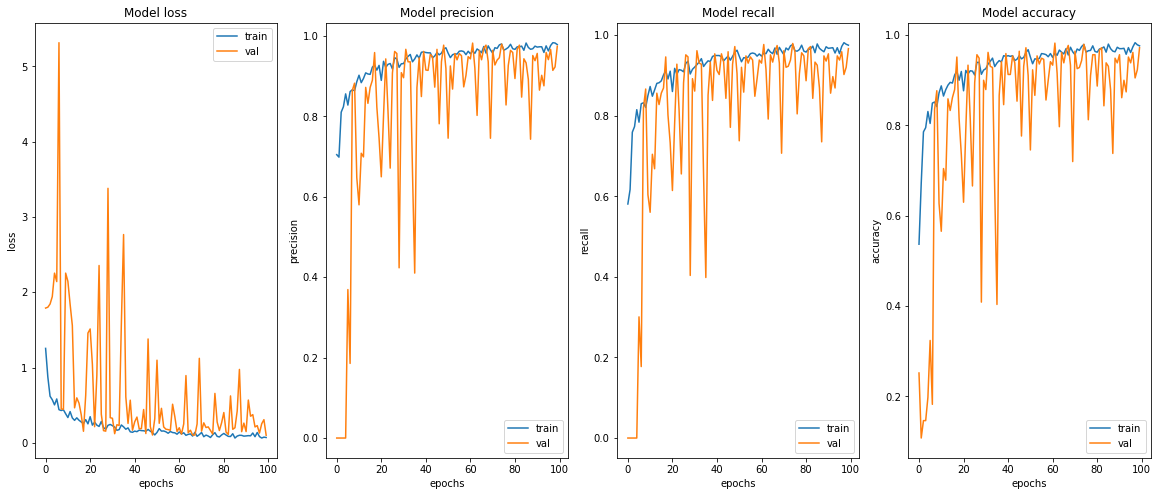

In [58]:
fig, ax = plt.subplots(1, 4, figsize=(20, 8))
ax = ax.ravel()
# plot the graph of the metrics
for i, met in enumerate(['loss', 'precision', 'recall', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [59]:
Xception_checkpoint = ModelCheckpoint(filepath='plant_clf_Xception.hdf5', save_best_only=True, save_weights_only=True)

In [60]:
# Fitting the model
history = Xception.fit(train_ds, 
                       epochs=50, 
                       validation_data=val_ds,
                       callbacks=[checkpoint, lr_reduce])

Epoch 1/50
81/81 [==============================] - 18s 217ms/step - loss: 0.0733 - accuracy: 0.9751 - precision: 0.9781 - recall: 0.9736 - truepositives: 1253.0000 - falsepositives: 28.0000 - auc: 0.9985 - val_loss: 0.1639 - val_accuracy: 0.9717 - val_precision: 0.9742 - val_recall: 0.9717 - val_truepositives: 378.0000 - val_falsepositives: 10.0000 - val_auc: 0.9934 - lr: 0.0010
Epoch 2/50
81/81 [==============================] - 18s 218ms/step - loss: 0.0464 - accuracy: 0.9845 - precision: 0.9844 - recall: 0.9821 - truepositives: 1264.0000 - falsepositives: 20.0000 - auc: 0.9998 - val_loss: 0.0784 - val_accuracy: 0.9743 - val_precision: 0.9742 - val_recall: 0.9717 - val_truepositives: 378.0000 - val_falsepositives: 10.0000 - val_auc: 0.9993 - lr: 0.0010
Epoch 3/50
81/81 [==============================] - 18s 218ms/step - loss: 0.0457 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - truepositives: 1266.0000 - falsepositives: 21.0000 - auc: 0.9998 - val_loss: 0.1616 - val_accu

Epoch 21/50
81/81 [==============================] - 18s 222ms/step - loss: 0.0126 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - truepositives: 1284.0000 - falsepositives: 3.0000 - auc: 1.0000 - val_loss: 0.0698 - val_accuracy: 0.9846 - val_precision: 0.9846 - val_recall: 0.9846 - val_truepositives: 383.0000 - val_falsepositives: 6.0000 - val_auc: 0.9967 - lr: 9.0000e-05
Epoch 22/50
81/81 [==============================] - 18s 222ms/step - loss: 0.0121 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9953 - truepositives: 1281.0000 - falsepositives: 5.0000 - auc: 1.0000 - val_loss: 0.0843 - val_accuracy: 0.9820 - val_precision: 0.9845 - val_recall: 0.9820 - val_truepositives: 382.0000 - val_falsepositives: 6.0000 - val_auc: 0.9967 - lr: 9.0000e-05
Epoch 23/50
81/81 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9961 - truepositives: 1282.0000 - falsepositives: 4.0000 - auc: 1.0000
Epoch 23: ReduceLROnPlateau re

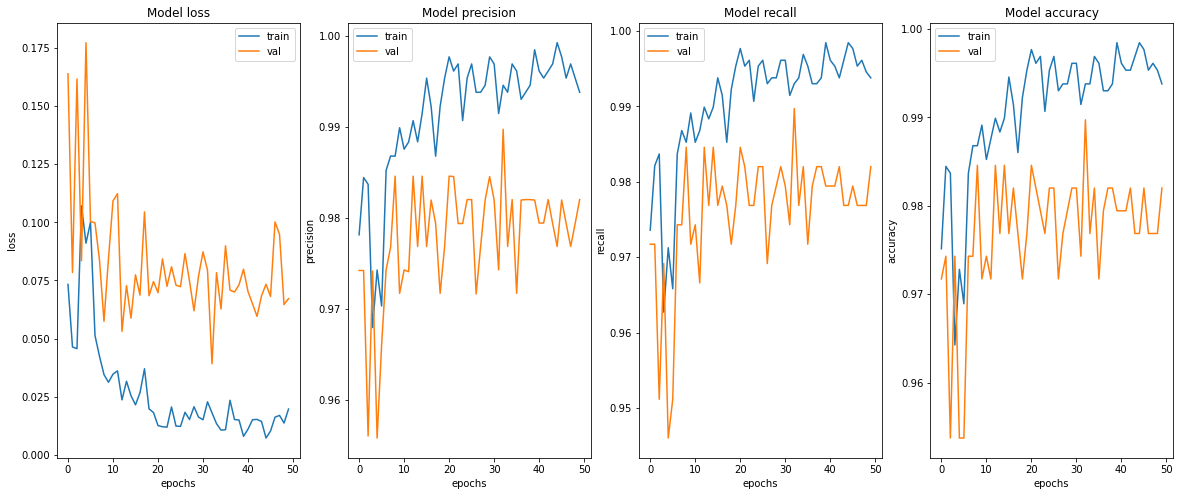

In [61]:
fig, ax = plt.subplots(1, 4, figsize=(20, 8))
ax = ax.ravel()
# plot the graph of the metrics
for i, met in enumerate(['loss', 'precision', 'recall', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [62]:
Xception.load_weights('plant_clf_Xception.hdf5')

In [63]:
loss, acc, precision, rec, truepositives, falsepositives, auc = Xception.evaluate(test_ds)

26/26 [==============================] - 2s 70ms/step - loss: 0.0547 - accuracy: 0.9782 - precision: 0.9805 - recall: 0.9782 - truepositives: 403.0000 - falsepositives: 8.0000 - auc: 0.9997


In [64]:
resultsDf3 = pd.concat([resultsDf2, createResultDf("Xception", loss, acc, precision, rec, truepositives, falsepositives, auc)])

resultsDf3

,CNN Arch,Loss,Test Score,Precision,Recall,TruePositives,FalsePositives,AUC
0,model,0.061842,0.975728,0.978102,0.975728,402.0,9.0,0.999611
0,MobileNetV2,0.088859,0.978155,0.977995,0.970874,400.0,9.0,0.999216
0,resnet50,0.105480,0.968447,0.970803,0.968447,399.0,12.0,0.997856
0,Xception,0.054681,0.978155,0.980535,0.978155,403.0,8.0,0.999692


              precision    recall  f1-score   support

  blackgrass       0.95      0.97      0.96        60
    charlock       1.00      1.00      1.00        90
    cleavers       1.00      1.00      1.00        68
     fat hen       1.00      0.96      0.98       100
       maize       0.96      1.00      0.98        46
       wheat       0.92      0.94      0.93        48

    accuracy                           0.98       412
   macro avg       0.97      0.98      0.97       412
weighted avg       0.98      0.98      0.98       412



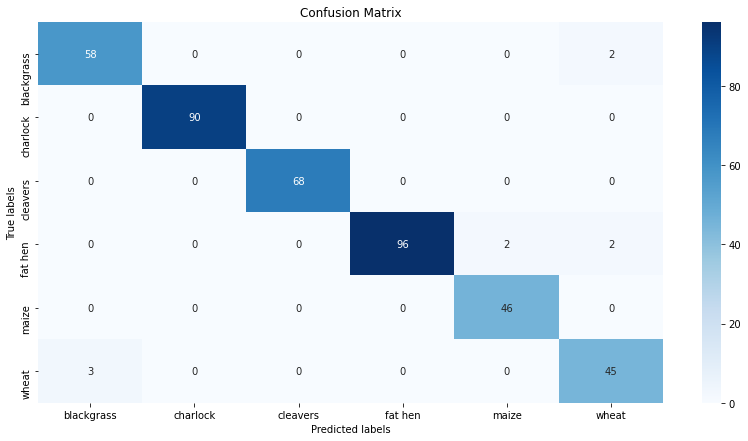

In [65]:
report(test_ds, Xception)

### DenseNet201

In [66]:
# Create the base model DenseNet201 from the pre-trained model 
DenseNet201 = tf.keras.applications.densenet.DenseNet201(input_shape=(128, 128, 3),
                                                         include_top=True,
                                                         classes=6,
                                                         weights=None)

DenseNet201.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_4[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']   

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 32, 32, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 16, 16, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 16, 16, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 16, 16, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 16, 16, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 8, 8, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 8, 8, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 8, 8, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 8, 8, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 8, 8, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 8, 8, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 8, 8, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 8, 8, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 8, 8, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 8, 8, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 8, 8, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 8, 8, 1024)  4096        ['conv4_block24_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 8, 8, 1024)  0           ['conv4_block25_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_1_conv (Conv2D)  (None, 8, 8, 128)    131072      ['conv4_block25_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 8, 8, 128)    147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block29_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block33_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 8, 8, 1312)  0           ['conv4_block32_concat[0][0]',   
 ate)                                                             'conv4_block33_2_conv[0][0]']   
                                                                                                  
 conv4_block34_0_bn (BatchNorma  (None, 8, 8, 1312)  5248        ['conv4_block33_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 8, 8, 1440)  5760        ['conv4_block37_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 8, 8, 1440)  0           ['conv4_block38_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block38_1_conv (Conv2D)  (None, 8, 8, 128)    184320      ['conv4_block38_0_relu[0][0]']   
                                                                                                  
 conv4_block38_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block38_1_conv[0][0]']   
 lization)

 conv4_block42_1_conv (Conv2D)  (None, 8, 8, 128)    200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block42_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block42_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 8, 8, 1728)  0           ['conv4_block45_concat[0][0]',   
 ate)                                                             'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 8, 8, 1728)  6912        ['conv4_block46_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block47_0_relu (Activati  (None, 8, 8, 1728)  0           ['conv4_block47_0_bn[0][0]']     
 on)      

 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 4, 4, 960)   0           ['conv5_block1_concat[0][0]',    
 te)                                                              'conv5_block2_2_conv[0][0]']    
                                                                                                  
 conv5_block3_0_bn (BatchNormal  (None, 4, 4, 960)   3840        ['conv5_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block7_0_bn (BatchNormal  (None, 4, 4, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 4, 4, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block7_1_conv (Conv2D)   (None, 4, 4, 128)    139264      ['conv5_block7_0_relu[0][0]']    
                                                                                                  
 conv5_block7_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block7_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block11_1_relu[0][0]']   
                                                                                                  
 conv5_block11_concat (Concaten  (None, 4, 4, 1248)  0           ['conv5_block10_concat[0][0]',   
 ate)     

 conv5_block15_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 4, 4, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_block16_0_bn (BatchNorma  (None, 4, 4, 1376)  5504        ['conv5_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block16_0_relu (Activati  (None, 4, 4, 1376)  0           ['conv5_block16_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block20_0_relu (Activati  (None, 4, 4, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 4, 4, 128)    192512      ['conv5_block20_0_relu[0][0]']   
                                                                                                  
 conv5_block20_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block20_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block24_1_relu[0][0]']   
                                                                                                  
 conv5_block24_concat (Concaten  (None, 4, 4, 1664)  0           ['conv5_block23_concat[0][0]',   
 ate)                                                             'conv5_block24_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block28_concat (Concaten  (None, 4, 4, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 4, 4, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block29_0_relu (Activati  (None, 4, 4, 1792)  0           ['conv5_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block29_1_conv (Conv2D)  (None, 4, 4, 128)    229376      ['conv5_block29_0_relu[0][0]']   
          

 avg_pool (GlobalAveragePooling  (None, 1920)        0           ['relu[0][0]']                   
 2D)                                                                                              
                                                                                                  
 predictions (Dense)            (None, 6)            11526       ['avg_pool[0][0]']               
                                                                                                  
Total params: 18,333,510
Trainable params: 18,104,454
Non-trainable params: 229,056
__________________________________________________________________________________________________


In [67]:
base_learning_rate = 0.001
DenseNet201.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=['categorical_crossentropy'],
              metrics=metrics)


In [68]:
# train the model
history = DenseNet201.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds)

Epoch 1/100
81/81 [==============================] - 50s 356ms/step - loss: 1.1814 - accuracy: 0.5765 - precision: 0.7221 - recall: 0.6239 - truepositives: 1060.0000 - falsepositives: 408.0000 - auc: 0.9254 - val_loss: 6.2869 - val_accuracy: 0.1465 - val_precision: 0.1465 - val_recall: 0.1465 - val_truepositives: 57.0000 - val_falsepositives: 332.0000 - val_auc: 0.4828
Epoch 2/100
81/81 [==============================] - 21s 254ms/step - loss: 0.8628 - accuracy: 0.6869 - precision: 0.7139 - recall: 0.6301 - truepositives: 811.0000 - falsepositives: 325.0000 - auc: 0.9261 - val_loss: 5.2975 - val_accuracy: 0.1465 - val_precision: 0.1465 - val_recall: 0.1465 - val_truepositives: 57.0000 - val_falsepositives: 332.0000 - val_auc: 0.5144
Epoch 3/100
81/81 [==============================] - 21s 259ms/step - loss: 0.7682 - accuracy: 0.7374 - precision: 0.7629 - recall: 0.6900 - truepositives: 888.0000 - falsepositives: 276.0000 - auc: 0.9414 - val_loss: 6.1479 - val_accuracy: 0.1465 - val_pre

Epoch 23/100
81/81 [==============================] - 21s 262ms/step - loss: 0.2888 - accuracy: 0.8998 - precision: 0.9074 - recall: 0.8912 - truepositives: 1147.0000 - falsepositives: 117.0000 - auc: 0.9902 - val_loss: 0.5902 - val_accuracy: 0.8098 - val_precision: 0.8206 - val_recall: 0.7995 - val_truepositives: 311.0000 - val_falsepositives: 68.0000 - val_auc: 0.9676
Epoch 24/100
81/81 [==============================] - 21s 261ms/step - loss: 0.2219 - accuracy: 0.9254 - precision: 0.9327 - recall: 0.9153 - truepositives: 1178.0000 - falsepositives: 85.0000 - auc: 0.9928 - val_loss: 0.8450 - val_accuracy: 0.7506 - val_precision: 0.7809 - val_recall: 0.7147 - val_truepositives: 278.0000 - val_falsepositives: 78.0000 - val_auc: 0.9393
Epoch 25/100
81/81 [==============================] - 21s 260ms/step - loss: 0.2375 - accuracy: 0.9184 - precision: 0.9260 - recall: 0.9138 - truepositives: 1176.0000 - falsepositives: 94.0000 - auc: 0.9922 - val_loss: 0.6953 - val_accuracy: 0.7841 - val_

81/81 [==============================] - 22s 267ms/step - loss: 0.2018 - accuracy: 0.9301 - precision: 0.9372 - recall: 0.9270 - truepositives: 1193.0000 - falsepositives: 80.0000 - auc: 0.9951 - val_loss: 1.2475 - val_accuracy: 0.7326 - val_precision: 0.7389 - val_recall: 0.7275 - val_truepositives: 283.0000 - val_falsepositives: 100.0000 - val_auc: 0.9187
Epoch 46/100
81/81 [==============================] - 22s 267ms/step - loss: 0.2050 - accuracy: 0.9215 - precision: 0.9248 - recall: 0.9176 - truepositives: 1181.0000 - falsepositives: 96.0000 - auc: 0.9945 - val_loss: 0.9086 - val_accuracy: 0.7815 - val_precision: 0.8177 - val_recall: 0.7609 - val_truepositives: 296.0000 - val_falsepositives: 66.0000 - val_auc: 0.9363
Epoch 47/100
81/81 [==============================] - 22s 266ms/step - loss: 0.1507 - accuracy: 0.9472 - precision: 0.9535 - recall: 0.9409 - truepositives: 1211.0000 - falsepositives: 59.0000 - auc: 0.9967 - val_loss: 0.1660 - val_accuracy: 0.9332 - val_precision: 0.

81/81 [==============================] - 21s 259ms/step - loss: 0.0758 - accuracy: 0.9728 - precision: 0.9743 - recall: 0.9705 - truepositives: 1249.0000 - falsepositives: 33.0000 - auc: 0.9986 - val_loss: 0.1312 - val_accuracy: 0.9666 - val_precision: 0.9666 - val_recall: 0.9666 - val_truepositives: 376.0000 - val_falsepositives: 13.0000 - val_auc: 0.9959
Epoch 90/100
81/81 [==============================] - 21s 259ms/step - loss: 0.1057 - accuracy: 0.9619 - precision: 0.9633 - recall: 0.9596 - truepositives: 1235.0000 - falsepositives: 47.0000 - auc: 0.9980 - val_loss: 0.4456 - val_accuracy: 0.8843 - val_precision: 0.8883 - val_recall: 0.8792 - val_truepositives: 342.0000 - val_falsepositives: 43.0000 - val_auc: 0.9735
Epoch 91/100
81/81 [==============================] - 21s 258ms/step - loss: 0.0765 - accuracy: 0.9751 - precision: 0.9759 - recall: 0.9744 - truepositives: 1254.0000 - falsepositives: 31.0000 - auc: 0.9989 - val_loss: 0.0985 - val_accuracy: 0.9743 - val_precision: 0.9

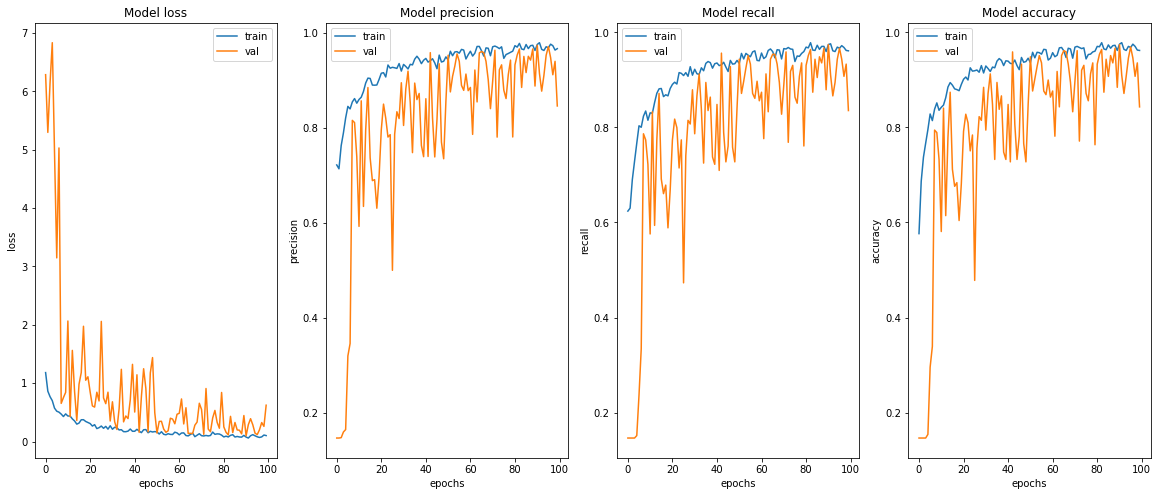

In [69]:
fig, ax = plt.subplots(1, 4, figsize=(20, 8))
ax = ax.ravel()
# plot the graph of the metrics
for i, met in enumerate(['loss', 'precision', 'recall', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [70]:
DenseNet201_checkpoint = ModelCheckpoint(filepath='plant_clf_DenseNet201.hdf5', save_best_only=True, save_weights_only=True)

In [71]:
# Fitting the model
history = DenseNet201.fit(train_ds, 
                              epochs=50, 
                              validation_data=val_ds,
                              callbacks=[checkpoint, lr_reduce])

Epoch 1/50
81/81 [==============================] - 21s 257ms/step - loss: 0.0700 - accuracy: 0.9689 - precision: 0.9696 - recall: 0.9681 - truepositives: 1246.0000 - falsepositives: 39.0000 - auc: 0.9994 - val_loss: 0.4299 - val_accuracy: 0.9049 - val_precision: 0.9115 - val_recall: 0.8997 - val_truepositives: 350.0000 - val_falsepositives: 34.0000 - val_auc: 0.9808 - lr: 0.0010
Epoch 2/50
81/81 [==============================] - 21s 257ms/step - loss: 0.1031 - accuracy: 0.9681 - precision: 0.9688 - recall: 0.9666 - truepositives: 1244.0000 - falsepositives: 40.0000 - auc: 0.9972 - val_loss: 1.0329 - val_accuracy: 0.7455 - val_precision: 0.7540 - val_recall: 0.7326 - val_truepositives: 285.0000 - val_falsepositives: 93.0000 - val_auc: 0.9357 - lr: 0.0010
Epoch 3/50
81/81 [==============================] - 21s 256ms/step - loss: 0.1127 - accuracy: 0.9604 - precision: 0.9618 - recall: 0.9596 - truepositives: 1235.0000 - falsepositives: 49.0000 - auc: 0.9975 - val_loss: 0.1956 - val_accu

Epoch 22/50
81/81 [==============================] - 10852s 136s/step - loss: 0.0223 - accuracy: 0.9922 - precision: 0.9930 - recall: 0.9922 - truepositives: 1277.0000 - falsepositives: 9.0000 - auc: 0.9999 - val_loss: 0.1112 - val_accuracy: 0.9717 - val_precision: 0.9717 - val_recall: 0.9717 - val_truepositives: 378.0000 - val_falsepositives: 11.0000 - val_auc: 0.9951 - lr: 3.0000e-04
Epoch 23/50
81/81 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9899 - truepositives: 1274.0000 - falsepositives: 12.0000 - auc: 0.9999
Epoch 23: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
81/81 [==============================] - 37225s 298ms/step - loss: 0.0257 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9899 - truepositives: 1274.0000 - falsepositives: 12.0000 - auc: 0.9999 - val_loss: 0.1630 - val_accuracy: 0.9563 - val_precision: 0.9588 - val_recall: 0.9563 - val_truepositives: 372.0000 - val_falsepositives:

Epoch 42/50
81/81 [==============================] - 20s 251ms/step - loss: 0.0140 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - truepositives: 1280.0000 - falsepositives: 7.0000 - auc: 1.0000 - val_loss: 0.0705 - val_accuracy: 0.9794 - val_precision: 0.9820 - val_recall: 0.9794 - val_truepositives: 381.0000 - val_falsepositives: 7.0000 - val_auc: 0.9982 - lr: 2.7000e-05
Epoch 43/50
81/81 [==============================] - 20s 250ms/step - loss: 0.0117 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - truepositives: 1285.0000 - falsepositives: 2.0000 - auc: 1.0000 - val_loss: 0.0915 - val_accuracy: 0.9794 - val_precision: 0.9793 - val_recall: 0.9743 - val_truepositives: 379.0000 - val_falsepositives: 8.0000 - val_auc: 0.9966 - lr: 2.7000e-05
Epoch 44/50
81/81 [==============================] - 20s 250ms/step - loss: 0.0151 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - truepositives: 1279.0000 - falsepositives: 8.0000 - auc: 1.0000 - val_loss: 0.0902 - va

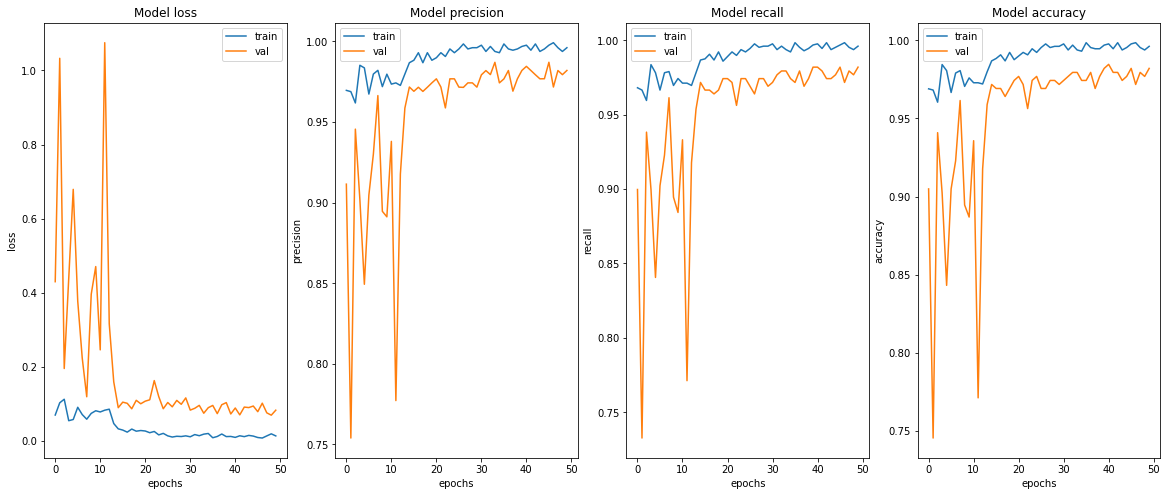

In [72]:
fig, ax = plt.subplots(1, 4, figsize=(20, 8))
ax = ax.ravel()
# plot the graph of the metrics
for i, met in enumerate(['loss', 'precision', 'recall', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [73]:
DenseNet201.load_weights('plant_clf_DenseNet201.hdf5')

In [74]:
loss, acc, precision, rec, truepositives, falsepositives, auc = DenseNet201.evaluate(test_ds)

26/26 [==============================] - 4s 145ms/step - loss: 0.0783 - accuracy: 0.9757 - precision: 0.9780 - recall: 0.9733 - truepositives: 401.0000 - falsepositives: 9.0000 - auc: 0.9995


In [75]:
resultsDf4 = pd.concat([resultsDf3, createResultDf("DenseNet201", loss, acc, precision, rec, truepositives, falsepositives, auc)])

resultsDf4

,CNN Arch,Loss,Test Score,Precision,Recall,TruePositives,FalsePositives,AUC
0,model,0.061842,0.975728,0.978102,0.975728,402.0,9.0,0.999611
0,MobileNetV2,0.088859,0.978155,0.977995,0.970874,400.0,9.0,0.999216
0,resnet50,0.105480,0.968447,0.970803,0.968447,399.0,12.0,0.997856
0,Xception,0.054681,0.978155,0.980535,0.978155,403.0,8.0,0.999692
0,DenseNet201,0.078307,0.975728,0.978049,0.973301,401.0,9.0,0.999451


              precision    recall  f1-score   support

  blackgrass       0.98      0.95      0.97        60
    charlock       0.97      1.00      0.98        90
    cleavers       1.00      0.94      0.97        68
     fat hen       1.00      0.97      0.98       100
       maize       0.94      1.00      0.97        46
       wheat       0.94      1.00      0.97        48

    accuracy                           0.98       412
   macro avg       0.97      0.98      0.97       412
weighted avg       0.98      0.98      0.98       412



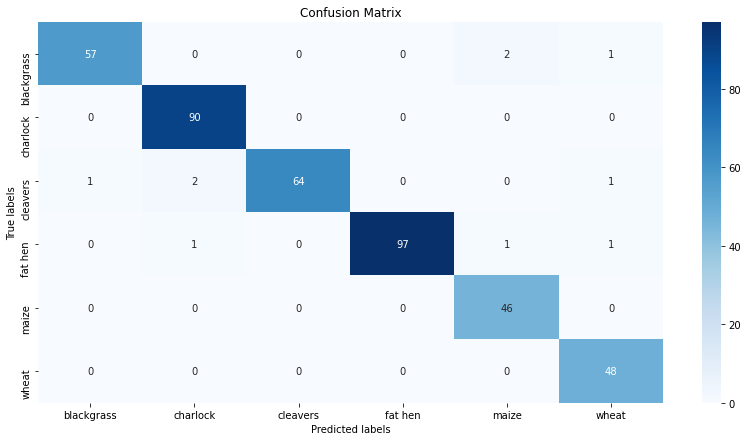

In [76]:
report(test_ds, DenseNet201)

In [77]:
df = resultsDf4.reset_index()
df['F1_score'] = [0.97, 0.97, 0.96, 0.97, 0.97]

In [78]:
df = df.drop('index', axis=1)
df

,CNN Arch,Loss,Test Score,Precision,Recall,TruePositives,FalsePositives,AUC
0,model,0.061842,0.975728,0.978102,0.975728,402.0,9.0,0.999611
1,MobileNetV2,0.088859,0.978155,0.977995,0.970874,400.0,9.0,0.999216
2,resnet50,0.105480,0.968447,0.970803,0.968447,399.0,12.0,0.997856
3,Xception,0.054681,0.978155,0.980535,0.978155,403.0,8.0,0.999692
4,DenseNet201,0.078307,0.975728,0.978049,0.973301,401.0,9.0,0.999451
